In [11]:
import sys
sys.path.append('src')

In [22]:
import pandas 
from itertools import product

In [31]:
from energiapy.components.analytical.player import Player
from energiapy.components.commodity.misc import Cash
from energiapy.components.commodity.emission import Emission
from energiapy.components.commodity.misc import Land
from energiapy.components.commodity.resource import Resource
from energiapy.components.operation.process import Process
from energiapy.components.operation.storage import Storage
from energiapy.components.operation.transit import Transit
from energiapy.components.spatial.linkage import Linkage

ImportError: cannot import name '_Component' from partially initialized module 'energiapy.components._base._component' (most likely due to a circular import) (/Users/cacodcar/Desktop/repos/energiapy/src/energiapy/components/_base/_component.py)

In [23]:
# _time_intervals = 7  # Number of time intervals in a planning horizon    (L_chi)
_exec_scenarios = 4  # Number of execution scenarios                     (chi)

M = 1e5  # Big M

In [24]:
def create_list(n_total: int, n: int):
    return [1] * n + [0] * (n_total - n)

In [25]:
def create_event_dict(n_total: int):
    default_list = [1] * n_total

    # If event names are same before '_'; they are considered mutually exclusive
    event_dict = {
        'cap2_1': {'prob': 0.05, 'factor': pandas.DataFrame(data={('loc2', 'com1_process'): create_list(n_total, 1)})},
        'cap2_2': {'prob': 0.075, 'factor': pandas.DataFrame(data={('loc2', 'com1_process'): create_list(n_total, 2)})},
        'cap2_3': {'prob': 0.125, 'factor': pandas.DataFrame(data={('loc2', 'com1_process'): create_list(n_total, 3)})},
        'cap2_4': {'prob': 0.75, 'factor': pandas.DataFrame(data={('loc2', 'com1_process'): default_list})},

        'cap4_1': {'prob': 0.01, 'factor': pandas.DataFrame(data={('loc4', 'com1_process'): create_list(n_total, 1)})},
        'cap4_2': {'prob': 0.05, 'factor': pandas.DataFrame(data={('loc4', 'com1_process'): create_list(n_total, 2)})},
        'cap4_3': {'prob': 0.1, 'factor': pandas.DataFrame(data={('loc4', 'com1_process'): create_list(n_total, 3)})},
        'cap4_4': {'prob': 0.84, 'factor': pandas.DataFrame(data={('loc4', 'com1_process'): default_list})},

        'cap7_1': {'prob': 0.05, 'factor': pandas.DataFrame(data={('loc7', 'com1_process'): create_list(n_total, 1)})},
        'cap7_2': {'prob': 0.05, 'factor': pandas.DataFrame(data={('loc7', 'com1_process'): create_list(n_total, 2)})},
        'cap7_3': {'prob': 0.1, 'factor': pandas.DataFrame(data={('loc7', 'com1_process'): create_list(n_total, 3)})},
        'cap7_4': {'prob': 0.8, 'factor': pandas.DataFrame(data={('loc7', 'com1_process'): default_list})},

        'res1_1': {'prob': 0.02, 'factor': pandas.DataFrame(data={('loc1', 'com1_pur'): create_list(n_total, 1)})},
        'res1_2': {'prob': 0.025, 'factor': pandas.DataFrame(data={('loc1', 'com1_pur'): create_list(n_total, 2)})},
        'res1_3': {'prob': 0.075, 'factor': pandas.DataFrame(data={('loc1', 'com1_pur'): create_list(n_total, 3)})},
        'res1_4': {'prob': 0.88, 'factor': pandas.DataFrame(data={('loc1', 'com1_pur'): default_list})},

        'res6_1': {'prob': 0.02, 'factor': pandas.DataFrame(data={('loc6', 'com1_pur'): create_list(n_total, 1)})},
        'res6_2': {'prob': 0.05, 'factor': pandas.DataFrame(data={('loc6', 'com1_pur'): create_list(n_total, 2)})},
        'res6_3': {'prob': 0.15, 'factor': pandas.DataFrame(data={('loc6', 'com1_pur'): create_list(n_total, 3)})},
        'res6_4': {'prob': 0.78, 'factor': pandas.DataFrame(data={('loc6', 'com1_pur'): default_list})},

        'trans12_2': {'prob': 0.2, 'factor': pandas.DataFrame(data={('trans12', 'com1_loc1_out'): create_list(n_total, 2)})},
        'trans12_4': {'prob': 0.8, 'factor': pandas.DataFrame(data={('trans12', 'com1_loc1_out'): default_list})},
        
        'trans25_2': {'prob': 0.05, 'factor': pandas.DataFrame(data={('trans25', 'com1_loc2_out'): create_list(n_total, 2)})},
        'trans25_4': {'prob': 0.95, 'factor': pandas.DataFrame(data={('trans25', 'com1_loc2_out'): default_list})},
    }

    return event_dict

In [26]:
# Function to generate the scenario dictionary for n sets of events
def create_scenario_dict(event_dict):
    # Extract unique event prefixes (e.g., 'cap2', 'cap4', ...)
    event_prefixes = set(key.split('_')[0] for key in event_dict)

    # Group events by their prefixes
    grouped_events = {prefix: [key for key in event_dict if key.startswith(prefix)] for prefix in event_prefixes}

    # Create all possible combinations of events across the different groups
    event_combinations = list(product(*grouped_events.values()))

    scenario_dict = {}

    # Iterate over all event combinations
    for combination in event_combinations:
        # Construct the scenario key
        scenario_key = '_'.join(combination)

        # Calculate the probability of this scenario
        prob = 1
        combined_factor = None

        for event_key in combination:
            # Multiply probabilities
            prob *= event_dict[event_key]['prob']

            # Combine factors (assumes they are pandas DataFrames)
            if combined_factor is None:
                combined_factor = event_dict[event_key]['factor'].copy()
            else:
                combined_factor = combined_factor.add(event_dict[event_key]['factor'], fill_value=0)

        # Add to the scenario dictionary
        scenario_dict[scenario_key] = {'prob': prob, 'factor': combined_factor}

    return scenario_dict

In [27]:
def build_model(scen_df=pandas.DataFrame()):
    default_df = pandas.DataFrame(data=[1] * _exec_scenarios)
    scale_factor = 90

    # Define temporal scales
    scales = TemporalScale(discretization_list=[1, _exec_scenarios])

    # ======================================================================================================================
    # Declare resources/commodities
    # ======================================================================================================================
    com1_pur = Resource(name='com1_pur', cons_max=225*scale_factor, block={'imp': 1, 'urg': 1}, price=0.00,
                        label='Commodity 1 consumed from outside the system',
                        varying=[VaryingResource.DETERMINISTIC_AVAILABILITY])

    com1_in = Resource(name='com1_in', label='Commodity 1 received')
    com1_out = Resource(name='com1_out', label='Commodity 1 to be sent out')

    com1_loc1_out = Resource(name='com1_loc1_out', label='Commodity 1 sent out from location 1')
    com1_loc2_out = Resource(name='com1_loc2_out', label='Commodity 1 sent out from location 2')
    com1_loc3_out = Resource(name='com1_loc3_out', label='Commodity 1 sent out from location 3')
    com1_loc4_out = Resource(name='com1_loc4_out', label='Commodity 1 sent out from location 4')
    com1_loc5_out = Resource(name='com1_loc5_out', label='Commodity 1 sent out from location 5')
    com1_loc6_out = Resource(name='com1_loc6_out', label='Commodity 1 sent out from location 6')
    com1_loc7_out = Resource(name='com1_loc7_out', label='Commodity 1 sent out from location 7')

    com1_sold = Resource(name='com1_sold', revenue=0.00, demand=True, sell=True,
                         label='Commodity 1 sold to outside the system')

    # ======================================================================================================================
    # Declare processes/storage capacities
    # ======================================================================================================================
    com1_process_capacity = 500*scale_factor

    # prod_max = {0: 0.25*com1_process_capacity, 1: 0.5*com1_process_capacity, 2: 0.75*com1_process_capacity, 3: 0.95*com1_process_capacity, 4: com1_process_capacity}
    # prod_min = {0: 0, 1: 0.25*com1_process_capacity, 2: 0.5*com1_process_capacity, 3: 0.75*com1_process_capacity, 4: 0.95*com1_process_capacity}
    # rate_max = {0:1.25/2, 1: 1/2, 2: 0.75/2, 3: 0.5/2, 4: 0.25/2}
    # mode_ramp = {(0,1): 5, (1,2): 5}

    com1_procure = Process(name='procure com1', prod_max=com1_process_capacity, conversion={com1_pur: -1, com1_in: 1},
                           capex=25/scale_factor, vopex=0.01, prod_min=0.01, label='Procure com1')
    com1_sell = Process(name='sell com1', prod_max=com1_process_capacity, conversion={com1_out: -1, com1_sold: 1},
                        capex=0.1/scale_factor, vopex=0.01, prod_min=0.01, label='Sell com1')
    # com1_opt_procure = Process(name='procure optional com1', prod_max=75, conversion={com1_pur: -1, com1_in:1}, capex=10, vopex=0.1, prod_min=0.01, label='Procure optional com1')

    com1_receive_loc1 = Process(name='com1_receive_loc1', prod_max=com1_process_capacity,
                                conversion={com1_loc1_out: -1, com1_in: 1}, capex=0.1/scale_factor, vopex=0.01, prod_min=0.01,
                                label='Commodity 1 received from location 1')
    com1_receive_loc2 = Process(name='com1_receive_loc2', prod_max=com1_process_capacity,
                                conversion={com1_loc2_out: -1, com1_in: 1}, capex=0.1/scale_factor, vopex=0.01, prod_min=0.01,
                                label='Commodity 1 received from location 2')
    com1_receive_loc3 = Process(name='com1_receive_loc3', prod_max=com1_process_capacity,
                                conversion={com1_loc3_out: -1, com1_in: 1}, capex=0.1/scale_factor, vopex=0.01, prod_min=0.01,
                                label='Commodity 1 received from location 3')
    com1_receive_loc4 = Process(name='com1_receive_loc4', prod_max=com1_process_capacity,
                                conversion={com1_loc4_out: -1, com1_in: 1}, capex=0.1/scale_factor, vopex=0.01, prod_min=0.01,
                                label='Commodity 1 received from location 4')
    com1_receive_loc5 = Process(name='com1_receive_loc5', prod_max=com1_process_capacity,
                                conversion={com1_loc5_out: -1, com1_in: 1}, capex=0.1/scale_factor, vopex=0.01, prod_min=0.01,
                                label='Commodity 1 received from location 5')
    com1_receive_loc6 = Process(name='com1_receive_loc6', prod_max=com1_process_capacity,
                                conversion={com1_loc6_out: -1, com1_in: 1}, capex=0.1/scale_factor, vopex=0.01, prod_min=0.01,
                                label='Commodity 1 received from location 6')
    com1_receive_loc7 = Process(name='com1_receive_loc7', prod_max=com1_process_capacity,
                                conversion={com1_loc7_out: -1, com1_in: 1}, capex=0.1/scale_factor, vopex=0.01, prod_min=0.01,
                                label='Commodity 1 received from location 7')

    com1_process = Process(name='com1_process', prod_max=com1_process_capacity, conversion={com1_in: -1, com1_out: 1},
                           capex=5/scale_factor, vopex=0.01, prod_min=0.01, label='Process the commodity through the location',
                           varying=[VaryingProcess.DETERMINISTIC_CAPACITY])

    com1_store = Process(name='com1_store', prod_max=com1_process_capacity, capex=0.5/scale_factor, vopex=0.01, storage_capex=30/scale_factor, store_min=0.01,
                         store_max=200*scale_factor, prod_min=0.01, label="Storage process", storage=com1_in, storage_cost=0.02)

    com1_loc1_send = Process(name='com1_loc1_send', prod_max=com1_process_capacity,
                             conversion={com1_out: -1, com1_loc1_out: 1}, capex=0.1/scale_factor, vopex=0.01, prod_min=0.01,
                             label='Send commodity one from location 1')
    com1_loc2_send = Process(name='com1_loc2_send', prod_max=com1_process_capacity,
                             conversion={com1_out: -1, com1_loc2_out: 1}, capex=0.1/scale_factor, vopex=0.01, prod_min=0.01,
                             label='Send commodity one from location 2')
    com1_loc3_send = Process(name='com1_loc3_send', prod_max=com1_process_capacity,
                             conversion={com1_out: -1, com1_loc3_out: 1}, capex=0.1/scale_factor, vopex=0.01, prod_min=0.01,
                             label='Send commodity one from location 3')
    com1_loc4_send = Process(name='com1_loc4_send', prod_max=com1_process_capacity,
                             conversion={com1_out: -1, com1_loc4_out: 1}, capex=0.1/scale_factor, vopex=0.01, prod_min=0.01,
                             label='Send commodity one from location 4')
    com1_loc5_send = Process(name='com1_loc5_send', prod_max=com1_process_capacity,
                             conversion={com1_out: -1, com1_loc5_out: 1}, capex=0.1/scale_factor, vopex=0.01, prod_min=0.01,
                             label='Send commodity one from location 5')
    com1_loc6_send = Process(name='com1_loc6_send', prod_max=com1_process_capacity,
                             conversion={com1_out: -1, com1_loc6_out: 1}, capex=0.1/scale_factor, vopex=0.01, prod_min=0.01,
                             label='Send commodity one from location 6')
    com1_loc7_send = Process(name='com1_loc7_send', prod_max=com1_process_capacity,
                             conversion={com1_out: -1, com1_loc7_out: 1}, capex=0.1/scale_factor, vopex=0.01, prod_min=0.01,
                             label='Send commodity one from location 7')

    # ======================================================================================================================
    # Declare locations/warehouses
    # ======================================================================================================================
    loc1 = Location(name='loc1',
                    processes={com1_procure, com1_receive_loc2, com1_receive_loc3, com1_process, com1_store,
                               com1_loc1_send}, label="Location 1",
                    scales=scales, demand_scale_level=1, capacity_scale_level=1, availability_scale_level=1,
                    availability_factor={
                        com1_pur: scen_df[[('loc1', 'com1_pur')]] if ('loc1', 'com1_pur') in scen_df else default_df})

    loc2 = Location(name='loc2',
                    processes={com1_receive_loc1, com1_receive_loc4, com1_receive_loc5, com1_process, com1_store,
                               com1_loc2_send}, label="Location 2", scales=scales, demand_scale_level=1,
                    capacity_scale_level=1, availability_scale_level=1,
                    capacity_factor={com1_process: scen_df[[('loc2', 'com1_process')]] if ('loc2',
                                                                                           'com1_process') in scen_df else default_df})

    loc3 = Location(name='loc3',
                    processes={com1_receive_loc1, com1_receive_loc4, com1_process, com1_store, com1_loc3_send},
                    label="Location 3", scales=scales, demand_scale_level=1, capacity_scale_level=1,
                    availability_scale_level=1)

    loc4 = Location(name='loc4', processes={com1_receive_loc2, com1_receive_loc3, com1_receive_loc6, com1_receive_loc5,
                                            com1_receive_loc7, com1_process, com1_store, com1_loc4_send},
                    label="Location 4", scales=scales, demand_scale_level=1, capacity_scale_level=1,
                    availability_scale_level=1,
                    capacity_factor={com1_process: scen_df[[('loc4', 'com1_process')]] if ('loc4',
                                                                                           'com1_process') in scen_df else default_df})

    loc5 = Location(name='loc5',
                    processes={com1_receive_loc2, com1_receive_loc4, com1_receive_loc7, com1_process, com1_store,
                               com1_loc5_send, com1_sell}, label="Location 5", scales=scales, demand_scale_level=1,
                    capacity_scale_level=1, availability_scale_level=1)

    loc6 = Location(name='loc6', processes={com1_procure, com1_receive_loc4, com1_process, com1_store, com1_loc6_send},
                    label="Location 6", scales=scales, demand_scale_level=1, capacity_scale_level=1,
                    availability_scale_level=1,
                    availability_factor={
                        com1_pur: scen_df[[('loc6', 'com1_pur')]] if ('loc6', 'com1_pur') in scen_df else default_df})

    loc7 = Location(name='loc7',
                    processes={com1_receive_loc4, com1_receive_loc5, com1_process, com1_store, com1_loc7_send},
                    label="Location 7", scales=scales, demand_scale_level=1, capacity_scale_level=1,
                    availability_scale_level=1,
                    capacity_factor={com1_process: scen_df[[('loc7', 'com1_process')]] if ('loc7',
                                                                                           'com1_process') in scen_df else default_df})

    # ======================================================================================================================
    # Declare transport/trucks
    # ======================================================================================================================

    truck_cap12 = 280*scale_factor
    truck_cap13 = 270*scale_factor
    truck_cap24 = 450*scale_factor
    truck_cap25 = 270*scale_factor
    truck_cap34 = 270*scale_factor
    truck_cap45 = 500*scale_factor
    truck_cap47 = 360*scale_factor
    truck_cap64 = 450*scale_factor
    truck_cap75 = 360*scale_factor

    truck12 = Transport(name='truck12', resources={com1_loc1_out}, trans_max=truck_cap12,
                        label='Truck from location 1 to 2', capex=0.5/scale_factor, vopex=0.05, trans_min=0.01, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    # truck21 = Transport(name='truck21', resources={com1_loc2_out}, trans_max=truck_cap12,
    #                     label='Truck from location 2 to 1', capex=0.0001, vopex=0.05, trans_min=0.01)

    truck13 = Transport(name='truck13', resources={com1_loc1_out}, trans_max=truck_cap13,
                        label='Truck from location 1 to 3', capex=0.3/scale_factor, vopex=0.03, trans_min=0.01, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    # truck31 = Transport(name='truck31', resources={com1_loc3_out}, trans_max=truck_cap13,
    #                     label='Truck from location 3 to 1', capex=0.0001, vopex=0.03, trans_min=0.01)

    truck24 = Transport(name='truck24', resources={com1_loc2_out}, trans_max=truck_cap24,
                        label='Truck from location 2 to 4', capex=0.5/scale_factor, vopex=0.05, trans_min=0.01, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    # truck42 = Transport(name='truck42', resources={com1_loc4_out}, trans_max=truck_cap24,
    #                     label='Truck from location 4 to 2', capex=0.0001, vopex=0.05, trans_min=0.01)

    truck25 = Transport(name='truck25', resources={com1_loc2_out}, trans_max=truck_cap25,
                        label='Truck from location 2 to 5', capex=0.3/scale_factor, vopex=0.03, trans_min=0.01, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    # truck52 = Transport(name='truck52', resources={com1_loc5_out}, trans_max=truck_cap25,
    #                     label='Truck from location 5 to 2', capex=0.0001, vopex=0.03, trans_min=0.01)

    truck34 = Transport(name='truck34', resources={com1_loc3_out}, trans_max=truck_cap34,
                        label='Truck from location 3 to 4', capex=0.2/scale_factor, vopex=0.02, trans_min=0.01, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    # truck43 = Transport(name='truck43', resources={com1_loc4_out}, trans_max=truck_cap34,
    #                     label='Truck from location 4 to 3', capex=0.0001, vopex=0.02, trans_min=0.01)

    truck45 = Transport(name='truck45', resources={com1_loc4_out}, trans_max=truck_cap45,
                        label='Truck from location 4 to 5', capex=1/scale_factor, vopex=0.1, trans_min=0.01, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    # truck54 = Transport(name='truck54', resources={com1_loc5_out}, trans_max=truck_cap45,
    #                     label='Truck from location 5 to 4', capex=0.0001, vopex=0.1, trans_min=0.01)

    truck47 = Transport(name='truck47', resources={com1_loc4_out}, trans_max=truck_cap47,
                        label='Truck from location 4 to 7', capex=0.4/scale_factor, vopex=0.04, trans_min=0.01, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    # truck74 = Transport(name='truck74', resources={com1_loc7_out}, trans_max=truck_cap47,
    #                     label='Truck from location 7 to 4', capex=0.0001, vopex=0.04, trans_min=0.01)

    truck64 = Transport(name='truck64', resources={com1_loc6_out}, trans_max=truck_cap64,
                        label='Truck from location 6 to 4', capex=0.5/scale_factor, vopex=0.05, trans_min=0.01, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    # truck46 = Transport(name='truck46', resources={com1_loc4_out}, trans_max=truck_cap64,
    #                     label='Truck from location 4 to 6', capex=0.0001, vopex=0.05, trans_min=0.01)

    truck75 = Transport(name='truck75', resources={com1_loc7_out}, trans_max=truck_cap75,
                        label='Truck from location 7 to 5', capex=0.4/scale_factor, vopex=0.04, trans_min=0.01, varying=[VaryingTransport.DETERMINISTIC_CAPACITY])
    # truck57 = Transport(name='truck57', resources={com1_loc5_out}, trans_max=truck_cap75,
    #                     label='Truck from location 5 to 7', capex=0.0001, vopex=0.04, trans_min=0.01)

    # ======================================================================================================================
    # Declare network
    # ======================================================================================================================

    transport_matrix = [
        [[], [truck12], [truck13], [], [], [], []],  # source: location 1
        [[], [], [], [truck24], [truck25], [], []],  # source: location 2
        [[], [], [], [truck34], [], [], []],  # source: location 3
        [[], [], [], [], [truck45], [], [truck47]],  # source: location 4
        [[], [], [], [], [], [], []],  # source: location 5
        [[], [], [], [truck64], [], [], []],  # source: location 6
        [[], [], [], [], [truck75], [], []]  # source: location 7
    ]

    # transport_matrix = [
    #     [[], [truck12], [truck13], [], [], [], []],  # source: location 1
    #     [[truck21], [], [], [truck24], [truck25], [], []],  # source: location 2
    #     [[truck31], [], [], [truck34], [], [], []],  # source: location 3
    #     [[], [truck42], [truck43], [], [truck45], [truck46], [truck47]],  # source: location 4
    #     [[], [truck52], [], [truck54], [], [], [truck57]],  # source: location 5
    #     [[], [], [], [truck64], [], [], []],  # source: location 6
    #     [[], [], [], [truck74], [truck75], [], []]  # source: location 7
    # ]

    distance_matrix = [
        [0, 55, 196, M, M, M, M],
        [55, 0, M, 163, 112, M, 134],
        [196, M, 0, 63, M, M, M],
        [M, 163, 63, 0, 95, 117, 88],
        [M, 112, M, 95, 0, M, 134],
        [M, M, M, 117, M, 0, M],
        [M, 134, M, 88, 134, M, 0]
    ]

    locset = [loc1, loc2, loc3, loc4, loc5, loc6, loc7]

    sources = locset
    sinks = locset

    network = Network(name='Network', scales=scales, source_locations=sources, sink_locations=sinks,
                      transport_matrix=transport_matrix, distance_matrix=distance_matrix, transport_capacity_scale_level=1,
                      transport_capacity_factor={(loc1, loc2): {truck12: scen_df[[('trans12', 'com1_loc1_out')]] if ('trans12', 'com1_loc1_out') in scen_df else default_df},
                                                 (loc1, loc3): {truck13: scen_df[[('trans13', 'com1_loc1_out')]] if ('trans13', 'com1_loc1_out') in scen_df else default_df},
                                                 (loc2, loc4): {truck24: scen_df[[('trans24', 'com1_loc2_out')]] if ('trans24', 'com1_loc2_out') in scen_df else default_df},
                                                 (loc2, loc5): {truck25: scen_df[[('trans25', 'com1_loc2_out')]] if ('trans25', 'com1_loc2_out') in scen_df else default_df},
                                                 (loc3, loc4): {truck34: scen_df[[('trans34', 'com1_loc3_out')]] if ('trans34', 'com1_loc3_out') in scen_df else default_df},
                                                 (loc4, loc5): {truck45: scen_df[[('trans45', 'com1_loc4_out')]] if ('trans45', 'com1_loc4_out') in scen_df else default_df},
                                                 (loc4, loc7): {truck47: scen_df[[('trans47', 'com1_loc4_out')]] if ('trans47', 'com1_loc4_out') in scen_df else default_df},
                                                 (loc6, loc4): {truck64: scen_df[[('trans64', 'com1_loc6_out')]] if ('trans64', 'com1_loc6_out') in scen_df else default_df},
                                                 (loc7, loc5): {truck75: scen_df[[('trans75', 'com1_loc7_out')]] if ('trans75', 'com1_loc7_out') in scen_df else default_df},
                                                 })

    # ======================================================================================================================
    # Declare scenario
    # ======================================================================================================================

    daily_demand = 400*scale_factor
    demand_penalty = 20

    demand_dict = {i: {com1_sold: daily_demand} if i == loc5 else {com1_sold: 0} for i in locset}
    demand_penalty_dict = {i: {com1_sold: demand_penalty} if i == loc5 else {com1_sold: 0} for i in locset}

    scenario = Scenario(name='scenario', scales=scales, scheduling_scale_level=1, network_scale_level=0,
                        purchase_scale_level=1, availability_scale_level=1, demand_scale_level=1,
                        capacity_scale_level=1, network=network, demand=demand_dict, demand_penalty=demand_penalty_dict,
                        label='Stochastic scenario with Multiple Locations')

    if scen_df.empty:
        # ======================================================================================================================
        # Declare problem
        # ======================================================================================================================

        problem_mincost = formulate(scenario=scenario,
                                    constraints={Constraints.COST, Constraints.TRANSPORT, Constraints.RESOURCE_BALANCE,
                                                 Constraints.INVENTORY, Constraints.PRODUCTION, Constraints.DEMAND,
                                                 Constraints.NETWORK},
                                    demand_sign='eq', objective=Objective.COST_W_DEMAND_PENALTY)

        scale_iter = scale_tuple(instance=problem_mincost, scale_levels=scenario.network_scale_level + 1)
        capex_process = sum(problem_mincost.Capex_network[scale_] for scale_ in scale_iter)
        cost_trans_capex = sum(problem_mincost.Capex_transport_network[scale_] for scale_ in scale_iter)

        problem_mincost.first_stage_cost = capex_process + cost_trans_capex

        return scenario, problem_mincost

    else:
        return scenario

In [28]:
def build_smodel(scen_df=pandas.DataFrame()):

    scenario = build_model(scen_df)
    # ======================================================================================================================
    # Declare problem
    # ======================================================================================================================

    problem_mincost = formulate(scenario=scenario,
                                constraints={Constraints.COST, Constraints.TRANSPORT, Constraints.RESOURCE_BALANCE,
                                             Constraints.INVENTORY, Constraints.PRODUCTION, Constraints.DEMAND,
                                             Constraints.NETWORK},
                                demand_sign='eq', objective=Objective.COST_W_DEMAND_PENALTY)

    scale_iter = scale_tuple(instance=problem_mincost, scale_levels=scenario.network_scale_level + 1)
    capex_process = sum(problem_mincost.Capex_network[scale_] for scale_ in scale_iter)
    cost_trans_capex = sum(problem_mincost.Capex_transport_network[scale_] for scale_ in scale_iter)

    problem_mincost.first_stage_cost = capex_process + cost_trans_capex

    return scenario, problem_mincost

In [29]:
def scenario_creator(scen_name, **kwargs):
    scen_dict = kwargs.get('scenario_dict')
    scen, model = build_smodel(scen_df=scen_dict[scen_name]['factor'])
    sputils.attach_root_node(model, model.first_stage_cost,
                             [model.X_P, model.Cap_P, model.X_S, model.Cap_S, model.X_F, model.Cap_F])
    model._mpisppy_probability = scen_dict[scen_name]['prob']
    return model

In [30]:
solver_options = {
    'MIPGap': 0.005,
    # 'TimeLimit': 60 * 15,
    'Heuristics': 0.20
}

event_dict = create_event_dict(n_total=_exec_scenarios)
scenario_dict = create_scenario_dict(event_dict=event_dict)
scenario_names = list(scenario_dict.keys())

# print(*scenario_names, sep='\n')
print(f"Sum of probabilities of all scenarios: {sum(scenario_dict[scen]['prob'] for scen in scenario_dict):.6f}")
print(f'Number of considered scenarios: {len(scenario_names)}')

exCost_PI = 0
results_PI = dict()
scen_PI, model_PI = build_model()

Sum of probabilities of all scenarios: 1.000000
Number of considered scenarios: 4096


NameError: name 'TemporalScale' is not defined

In [10]:
# Deterministic Scenarios for Perfect Information
counter = 0
for scen_name in scenario_names:
    scen_PI = build_model(scen_df=scenario_dict[scen_name]['factor'])
    counter+=1
    # Delete process capacity factors, resource availability factors, transport capacity factors
    model_PI.del_component('constraint_nameplate_production_varying_capacity')
    model_PI.del_component('constraint_resource_consumption_varying')
    model_PI.del_component('constraint_export')

    # Add the constraints back for this particular scenario
    model_PI.constraint_nameplate_production_varying_capacity = make_constraint(instance=model_PI,
        type_cons=Cons.X_LEQ_BY, variable_x='P', location_set=model_PI.locations, component_set=model_PI.processes_varying_capacity,
        loc_comp_dict=scen_PI.location_process_dict, b_factor=scen_PI.capacity_factor,
                                                                                x_scale_level=scen_PI.scheduling_scale_level,
                                                                                b_scale_level=scen_PI.capacity_scale_level,
                                                                                y_scale_level=scen_PI.network_scale_level,
                                                                                variable_y='Cap_P',
                                                                                label='restricts production to varying nameplate capacity')

    model_PI.constraint_resource_consumption_varying = make_constraint(
        instance=model_PI, type_cons=Cons.X_LEQ_B, variable_x='C', location_set=model_PI.locations,
        component_set=model_PI.resources_varying_availability, b_max=scen_PI.cons_max,
        loc_comp_dict=scen_PI.location_resource_dict, b_factor=scen_PI.availability_factor,
        x_scale_level=scen_PI.scheduling_scale_level, b_scale_level=scen_PI.availability_scale_level,
        label='restricts resource consumption to varying availablity')

    constraint_export(instance=model_PI, scheduling_scale_level=scen_PI.scheduling_scale_level,
                      network_scale_level=scen_PI.network_scale_level,
                      location_transport_resource_dict=scen_PI.location_transport_resource_dict,
                      transport_capacity_factor=scen_PI.transport_capacity_factor,
                      transport_capacity_scale_level=scen_PI.transport_capacity_scale_level)

    results_PI = solve(scenario=scen_PI, instance=model_PI, solver='gurobi', name=scen_name,
                       solver_options=solver_options)

    print('######################## Finished solving ' + scen_name + ' ('+ str(counter) +' of ' + str(len(scenario_dict)) + ') ########################')

    exCost_PI += value(model_PI.objective_cost_w_demand_penalty) * scenario_dict[scen_name]['prob']

constraint export
Set parameter MIPGap to value 0.005
Set parameter Heuristics to value 0.2
Set parameter QCPDual to value 1
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: 13th Gen Intel(R) Core(TM) i7-13700, instruction set [SSE2|AVX|AVX2]
Thread count: 16 physical cores, 24 logical processors, using up to 24 threads

Optimize a model with 9762 rows, 18516 columns and 14979 nonzeros
Model fingerprint: 0x72ced7ae
Variable types: 17935 continuous, 581 integer (581 binary)
Coefficient statistics:
  Matrix range     [1e-03, 5e+04]
  Objective range  [1e+00, 2e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+04, 5e+04]
Found heuristic solution: objective 2880000.0000
Presolve removed 9564 rows and 18388 columns
Presolve time: 0.01s
Presolved: 198 rows, 128 columns, 435 nonzeros
Variable types: 82 continuous, 46 integer (46 binary)

Root relaxation: objective 2.564543e+06, 61 iterations, 0.00 seconds (0.00 work units)

    Nodes   

In [11]:
print(f"Total Expected Cost considering perfect information: {exCost_PI:.4f}")

Total Expected Cost considering perfect information: 1734127.0769


In [12]:
# options = {"solver": "gurobi"}
# scenario_creator_kwargs = {'scenario_dict': scenario_dict}
# ef_UI = ExtensiveForm(options, scenario_names, scenario_creator, scenario_creator_kwargs=scenario_creator_kwargs)
# results = ef_UI.solve_extensive_form(solver_options=solver_options)

In [12]:
exCost_UI = 1774511.7829
EVPI = exCost_UI - exCost_PI
p_inc = EVPI * 100 / exCost_PI
p_dec = EVPI * 100 / exCost_UI

In [14]:
with open('ssoln_IE_ML_SD_S.pkl', 'rb') as file:
    ssoln_dict = pickle.load(file)

In [13]:
# ssoln_dict = ef_UI.get_root_solution()
# 
# with open('ssoln_IE_MultiLoc_stochastic.pkl', 'wb') as file:
#     pickle.dump(ssoln_dict, file)
# 
print(f"Total Expected Cost considering perfect information: {exCost_PI:.4f}")
print(f"Total Expected Cost considering disruptions (stochastic solution): {exCost_UI:.4f}")
print(f"Expected Value of Perfect Information: {EVPI:.4f}")
print(f"Percentage Increase in Cost: {p_inc:.4f}%%")
print(f"Percentage Decrease in Cost: {p_dec:.4f}%%")


Total Expected Cost considering perfect information: 1734127.0769
Total Expected Cost considering disruptions (stochastic solution): 1774511.7829
Expected Value of Perfect Information: 40384.7060
Percentage Increase in Cost: 2.3288%%
Percentage Decrease in Cost: 2.2758%%


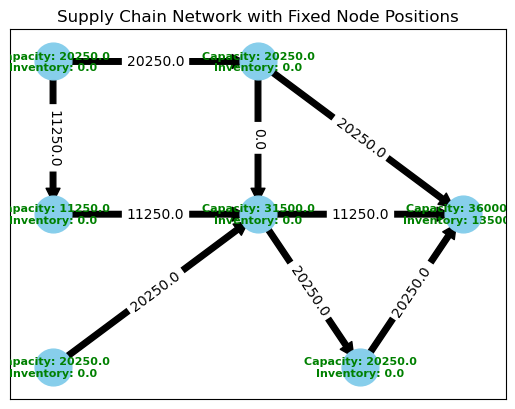

In [15]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a directed graph
G = nx.DiGraph()

# Define nodes (suppliers, factories, warehouses, etc.) with additional labels
nodes = {
    'Location 1': {
        'Capacity': ssoln_dict['Cap_P[loc1,com1_process,0]'] if 'Cap_P[loc1,com1_process,0]' in ssoln_dict.keys() else 0,
        'Inventory': ssoln_dict['Cap_S[loc1,com1_store_com1_in_stored,0]'] if 'Cap_S[loc1,com1_store_com1_in_stored,0]' in ssoln_dict.keys() else 0
    },
    'Location 2': {
        'Capacity': ssoln_dict['Cap_P[loc2,com1_process,0]'] if 'Cap_P[loc2,com1_process,0]' in ssoln_dict.keys() else 0,
        'Inventory': ssoln_dict['Cap_S[loc2,com1_store_com1_in_stored,0]'] if 'Cap_S[loc2,com1_store_com1_in_stored,0]' in ssoln_dict.keys() else 0
    },
    'Location 3': {
        'Capacity': ssoln_dict['Cap_P[loc3,com1_process,0]'] if 'Cap_P[loc3,com1_process,0]' in ssoln_dict.keys() else 0,
        'Inventory': ssoln_dict['Cap_S[loc3,com1_store_com1_in_stored,0]'] if 'Cap_S[loc3,com1_store_com1_in_stored,0]' in ssoln_dict.keys() else 0
    },
    'Location 4': {
        'Capacity': ssoln_dict['Cap_P[loc4,com1_process,0]'] if 'Cap_P[loc4,com1_process,0]' in ssoln_dict.keys() else 0,
        'Inventory': ssoln_dict['Cap_S[loc4,com1_store_com1_in_stored,0]'] if 'Cap_S[loc4,com1_store_com1_in_stored,0]' in ssoln_dict.keys() else 0
    },
    'Location 5': {
        'Capacity': ssoln_dict['Cap_P[loc5,com1_process,0]'] if 'Cap_P[loc5,com1_process,0]' in ssoln_dict.keys() else 0,
        'Inventory': ssoln_dict['Cap_S[loc5,com1_store_com1_in_stored,0]'] if 'Cap_S[loc5,com1_store_com1_in_stored,0]' in ssoln_dict.keys() else 0
    },
    'Location 6': {
        'Capacity': ssoln_dict['Cap_P[loc6,com1_process,0]'] if 'Cap_P[loc6,com1_process,0]' in ssoln_dict.keys() else 0,
        'Inventory': ssoln_dict['Cap_S[loc6,com1_store_com1_in_stored,0]'] if 'Cap_S[loc6,com1_store_com1_in_stored,0]' in ssoln_dict.keys() else 0
    },
    'Location 7': {
        'Capacity': ssoln_dict['Cap_P[loc7,com1_process,0]'] if 'Cap_P[loc7,com1_process,0]' in ssoln_dict.keys() else 0,
        'Inventory': ssoln_dict['Cap_S[loc7,com1_store_com1_in_stored,0]'] if 'Cap_S[loc7,com1_store_com1_in_stored,0]' in ssoln_dict.keys() else 0
    },
}

# Add nodes to the graph
G.add_nodes_from(nodes.keys())

# Define edges (connections between nodes)
edges = [
    ('Location 1', 'Location 2', {'weight': ssoln_dict['Cap_F[loc1,loc2,truck12,0]'] if 'Cap_F[loc1,loc2,truck12,0]' in ssoln_dict.keys() else 0}),
    ('Location 1', 'Location 3', {'weight': ssoln_dict['Cap_F[loc1,loc3,truck13,0]'] if 'Cap_F[loc1,loc3,truck13,0]' in ssoln_dict.keys() else 0}),
    ('Location 2', 'Location 4', {'weight': ssoln_dict['Cap_F[loc2,loc4,truck24,0]'] if 'Cap_F[loc2,loc4,truck24,0]' in ssoln_dict.keys() else 0}),
    ('Location 2', 'Location 5', {'weight': ssoln_dict['Cap_F[loc2,loc5,truck25,0]'] if 'Cap_F[loc2,loc5,truck25,0]' in ssoln_dict.keys() else 0}),
    ('Location 3', 'Location 4', {'weight': ssoln_dict['Cap_F[loc3,loc4,truck34,0]'] if 'Cap_F[loc3,loc4,truck34,0]' in ssoln_dict.keys() else 0}),
    ('Location 4', 'Location 5', {'weight': ssoln_dict['Cap_F[loc4,loc5,truck45,0]'] if 'Cap_F[loc4,loc5,truck45,0]' in ssoln_dict.keys() else 0}),
    ('Location 4', 'Location 7', {'weight': ssoln_dict['Cap_F[loc4,loc7,truck47,0]'] if 'Cap_F[loc4,loc7,truck47,0]' in ssoln_dict.keys() else 0}),
    ('Location 6', 'Location 4', {'weight': ssoln_dict['Cap_F[loc6,loc4,truck64,0]'] if 'Cap_F[loc6,loc4,truck64,0]' in ssoln_dict.keys() else 0}),
    ('Location 7', 'Location 5', {'weight': ssoln_dict['Cap_F[loc7,loc5,truck75,0]'] if 'Cap_F[loc7,loc5,truck75,0]' in ssoln_dict.keys() else 0}),
]

# Add edges to the graph
G.add_edges_from(edges)

# Define fixed positions for nodes
fixed_positions = {
    'Location 1': (-2, 2),
    'Location 2': (0, 2),
    'Location 3': (-2, 0),
    'Location 4': (0, 0),
    'Location 5': (2, 0),
    'Location 6': (-2, -2),
    'Location 7': (1, -2)
}

# Create custom labels combining multiple pieces of information
node_labels = {node: f"Capacity: {data['Capacity']}\nInventory: {data['Inventory']}" for node, data in nodes.items()}

# Draw nodes and edges with fixed positions
nx.draw_networkx_nodes(G, fixed_positions, node_color='skyblue', node_size=700)
nx.draw_networkx_edges(G, fixed_positions, edgelist=edges, arrowstyle='simple', arrowsize=20)
nx.draw_networkx_labels(G, fixed_positions, labels=node_labels, font_size=8, font_color='green', font_weight='bold')

# Draw edge labels (optional)
edge_labels = {(u, v): d['weight'] for u, v, d in G.edges(data=True)}
nx.draw_networkx_edge_labels(G, fixed_positions, edge_labels=edge_labels)

# Show the plot
plt.title("Supply Chain Network with Fixed Node Positions")
plt.show()
